In [152]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, log_loss

In [239]:
tqdm.pandas()
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(10,6)})

In [243]:
# Code Courtesy : AAIC
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)  
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,6))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(10,6))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(10,6))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [3]:
!ls ./train/

training_text  training_variants


In [10]:
!head -n 3 ./train/training_variants

ID,Gene,Variation,Class
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2


In [73]:
data_variant = pd.read_csv('./train/training_variants')
data_text = pd.read_csv('./train/training_text', sep='\|\|', engine='python', names=['ID', 'TEXT'], skiprows=1)

In [33]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [34]:
data_text.shape

(3321, 2)

In [35]:
data_variant.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [36]:
data_variant.shape

(3321, 4)

In [37]:
assert(data_text.shape[0] == data_variant.shape[0])

### Text Cleaning

In [74]:
def clean_text(text):
    if text == text: # Best way to check if the value is nan
        text = text.replace(',', '')
        text = text.replace('(', '')
        text = text.replace(')', '')
        text = text.replace('[', '')
        text = text.replace(']', '')
        text = text.replace('.', '')
        text = text.lower()
        return text

In [75]:
data_text['TEXT'] = data_text.TEXT.apply(lambda x: clean_text(x))

In [76]:
data_text.head()

,ID,TEXT
0,0,cyclin-dependent kinases cdks regulate a varie...
1,1,abstract background non-small cell lung canc...
2,2,abstract background non-small cell lung canc...
3,3,recent evidence has demonstrated that acquired...
4,4,oncogenic mutations in the monomeric casitas b...


### Merging the two dataframes

In [78]:
data = pd.merge(data_variant, data_text, on='ID')

In [79]:
data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin-dependent kinases cdks regulate a varie...
1,1,CBL,W802*,2,abstract background non-small cell lung canc...
2,2,CBL,Q249E,2,abstract background non-small cell lung canc...
3,3,CBL,N454D,3,recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,oncogenic mutations in the monomeric casitas b...


In [80]:
data.shape

(3321, 5)

### Checkpoint 1

In [81]:
data.to_csv('./train/train.csv', index=False)

### Filling the NaN values

In [85]:
null_ids = data[data.isnull().any(axis=1)].ID

In [101]:
fill = data.loc[data.ID.isin(null_ids), ['Gene']].Gene + ' ' + data.loc[data.ID.isin(null_ids), ['Variation']].Variation

In [102]:
data.loc[data.ID.isin(null_ids), 'TEXT'] = fill

In [104]:
data.loc[data.ID.isin(null_ids),]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


### Splitting the data into train-cv-test

In [106]:
y = data['Class'].values

In [107]:
y

array([1, 2, 2, ..., 1, 4, 4])

In [111]:
data.drop('Class', axis=1, inplace=True)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [119]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [118]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_cv.shape[0] == y_cv.shape[0])
assert(X_test.shape[0] == y_test.shape[0])

### Checkpoint 2

In [120]:
!mkdir dataset

In [122]:
X_train.to_csv('./dataset/train.csv', index=False)
np.save('./dataset/train_label.npy', y_train)

X_cv.to_csv('./dataset/cv.csv', index=False)
np.save('./dataset/cv_label.npy', y_cv)

X_test.to_csv('./dataset/test.csv', index=False)
np.save('./dataset/test_label.npy', y_test)

### Distribution of class labels in datasets

In [127]:
train = X_train.copy()
train['class'] = y_train

cv = X_cv.copy()
cv['class'] = y_cv

test = X_test.copy()
test['class'] = y_test

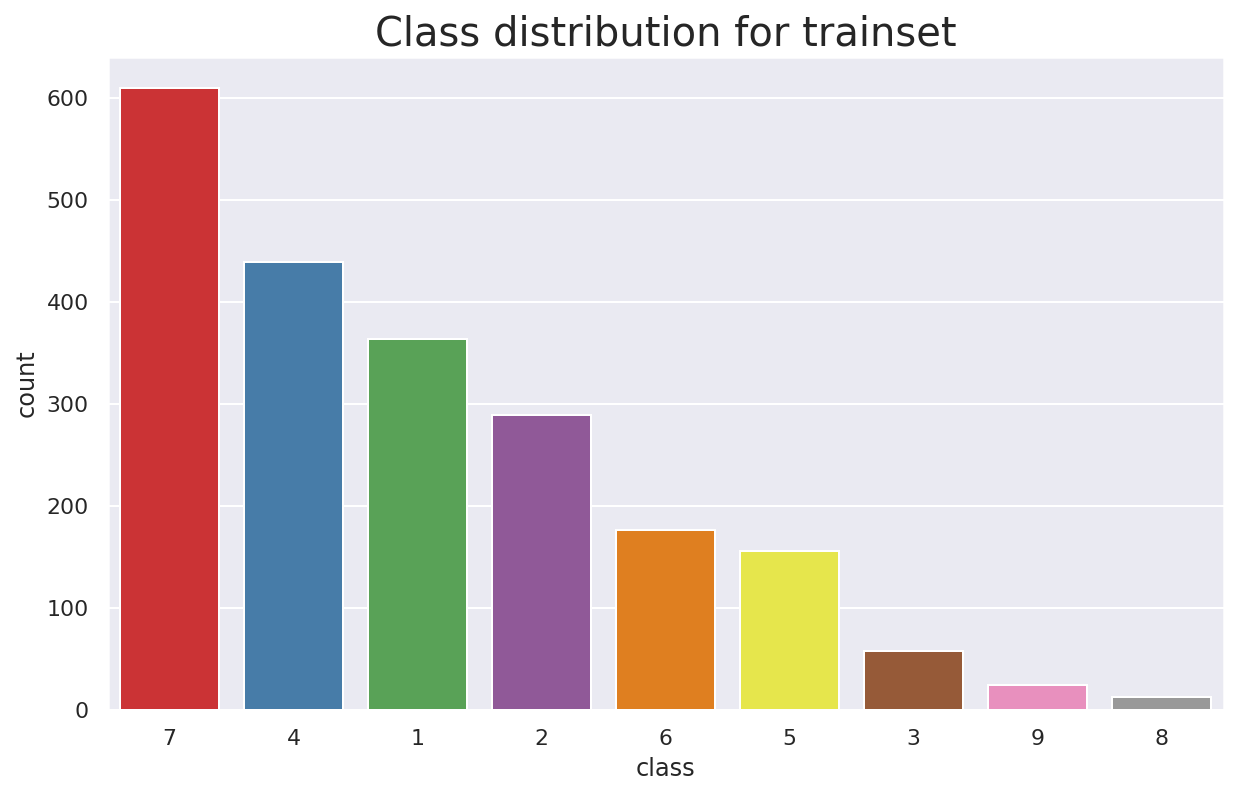

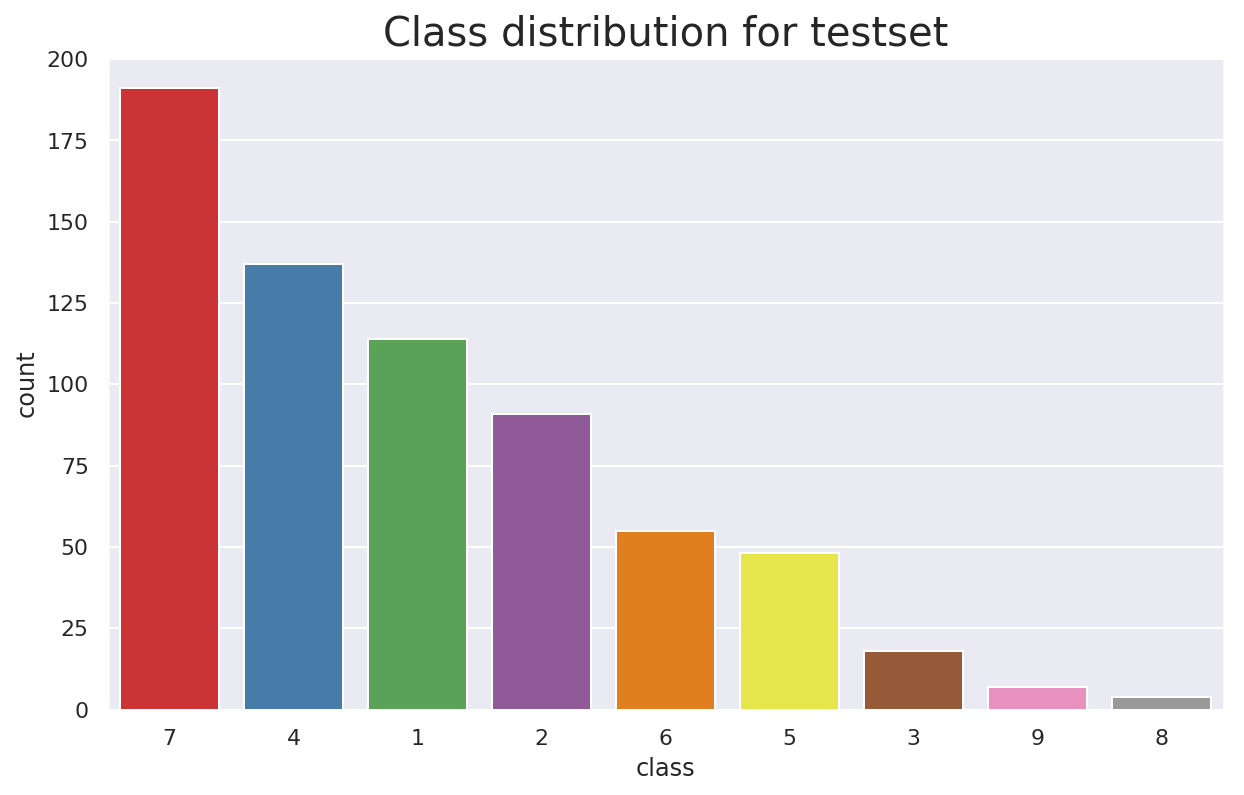

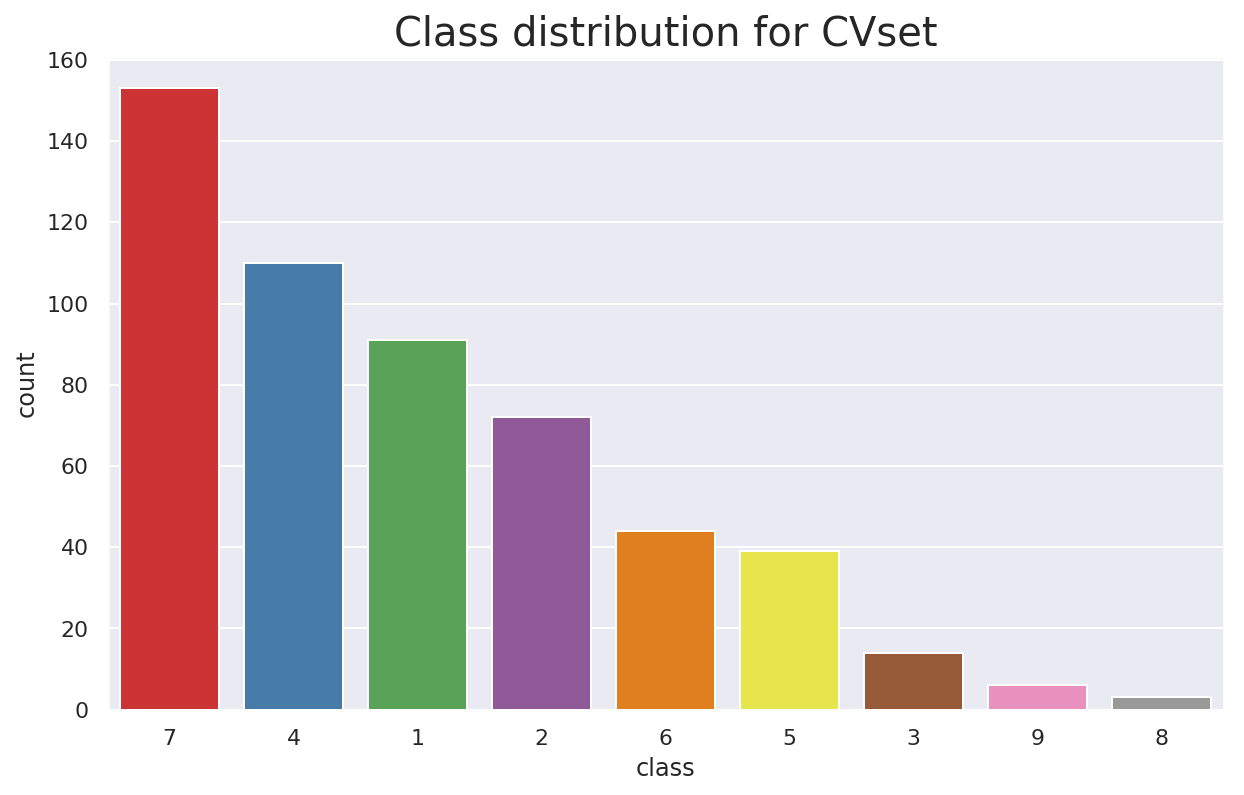

In [150]:
sns.countplot(x='class', data=train, palette='Set1',
             order=train['class'].value_counts().index);
plt.title('Class distribution for trainset', fontsize=20);
plt.show()
sns.countplot(x='class', data=test, palette='Set1',
             order=test['class'].value_counts().index);
plt.title('Class distribution for testset', fontsize=20);
plt.show()
sns.countplot(x='class', data=cv, palette='Set1',
             order=cv['class'].value_counts().index);
plt.title('Class distribution for CVset', fontsize=20);
plt.show()

### Random Model

In [158]:
np.random.seed(42)

In [216]:
def create_random_model(X, y_true):
    n = X.shape[0]
    rp = np.random.rand(n, 9)
    y_pred = rp / np.sum(rp, axis=1).reshape(n, -1)
    return y_pred, log_loss(y_true, y_pred)

In [218]:
print('Train log-loss of Random Model: ' , create_random_model(X_train, y_train)[1])
print('CV log-loss of Random Model: ' , create_random_model(X_cv, y_cv)[1])
test_preds, test_ll = create_random_model(X_test, y_test)
print('Test log-loss of Random Model: ' , test_ll)

Train log-loss of Random Model:  2.4767644250515577
CV log-loss of Random Model:  2.5516990837915765
Test log-loss of Random Model:  2.4881167287571


In [228]:
y_test_pred = np.argmax(test_preds, axis=1) + 1

-------------------- Confusion matrix --------------------


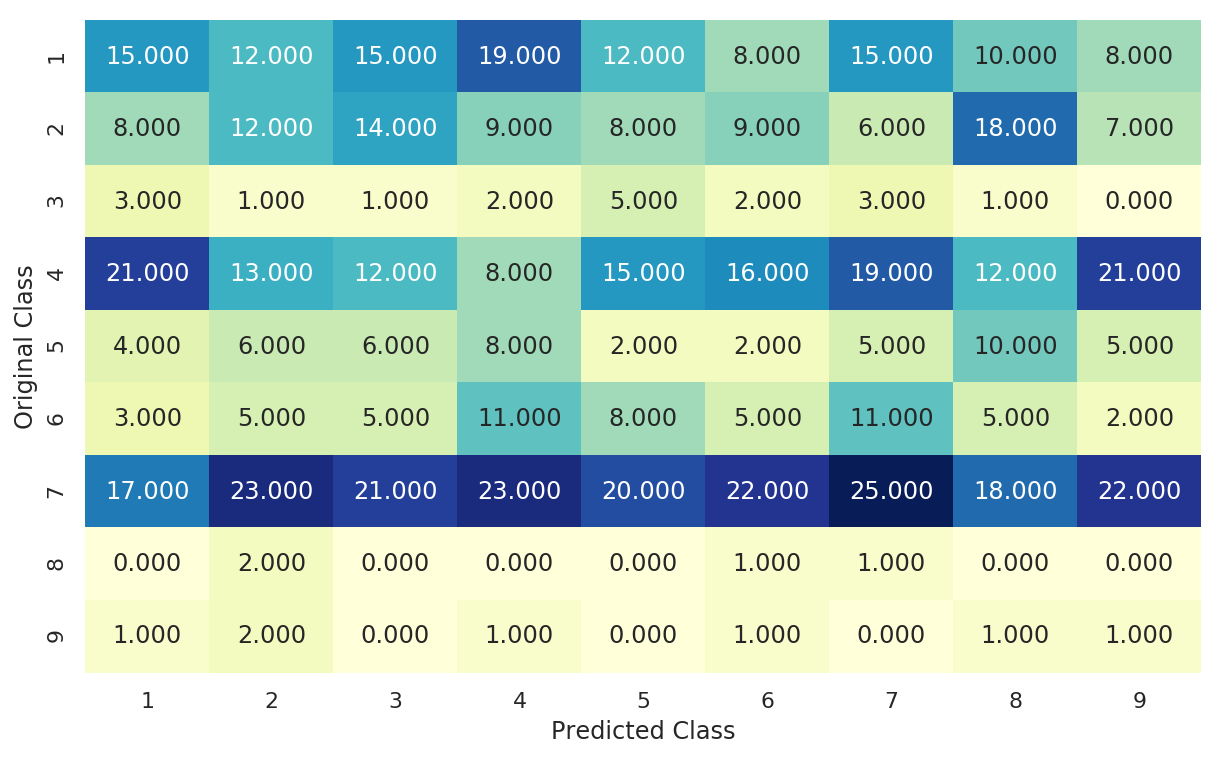

-------------------- Precision matrix (Columm Sum=1) --------------------


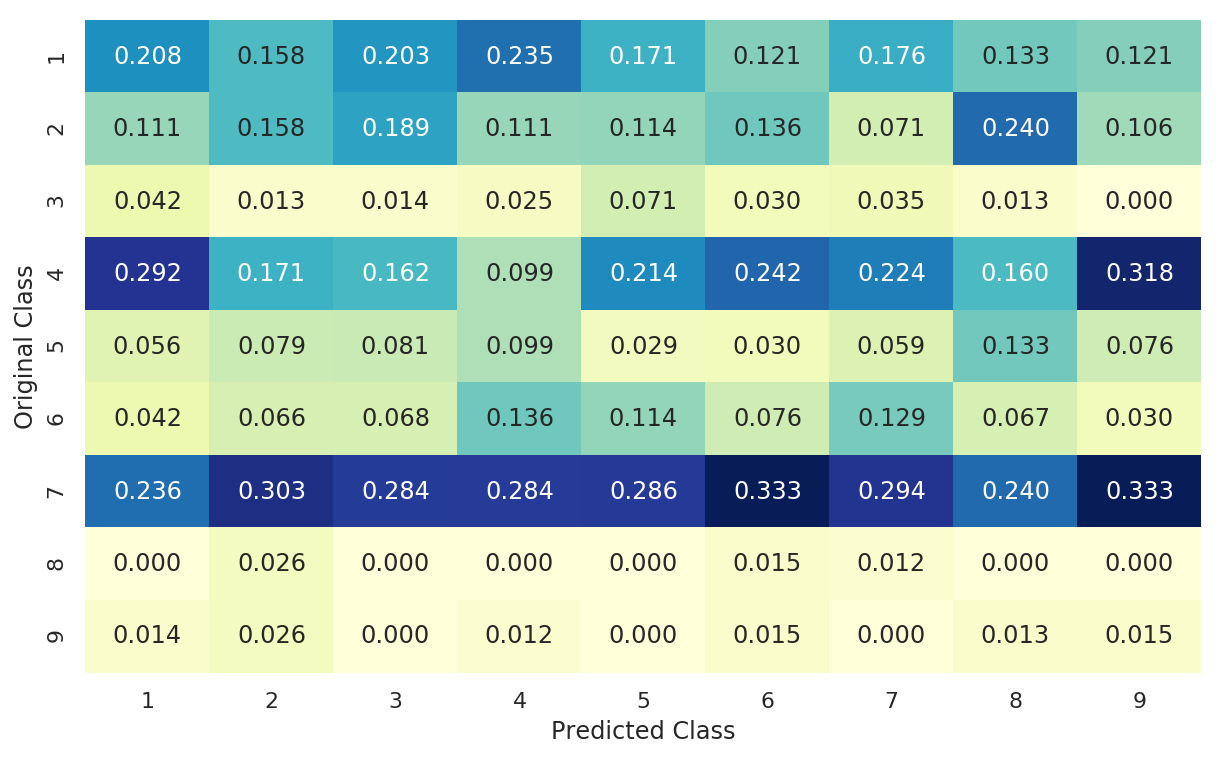

-------------------- Recall matrix (Row sum=1) --------------------


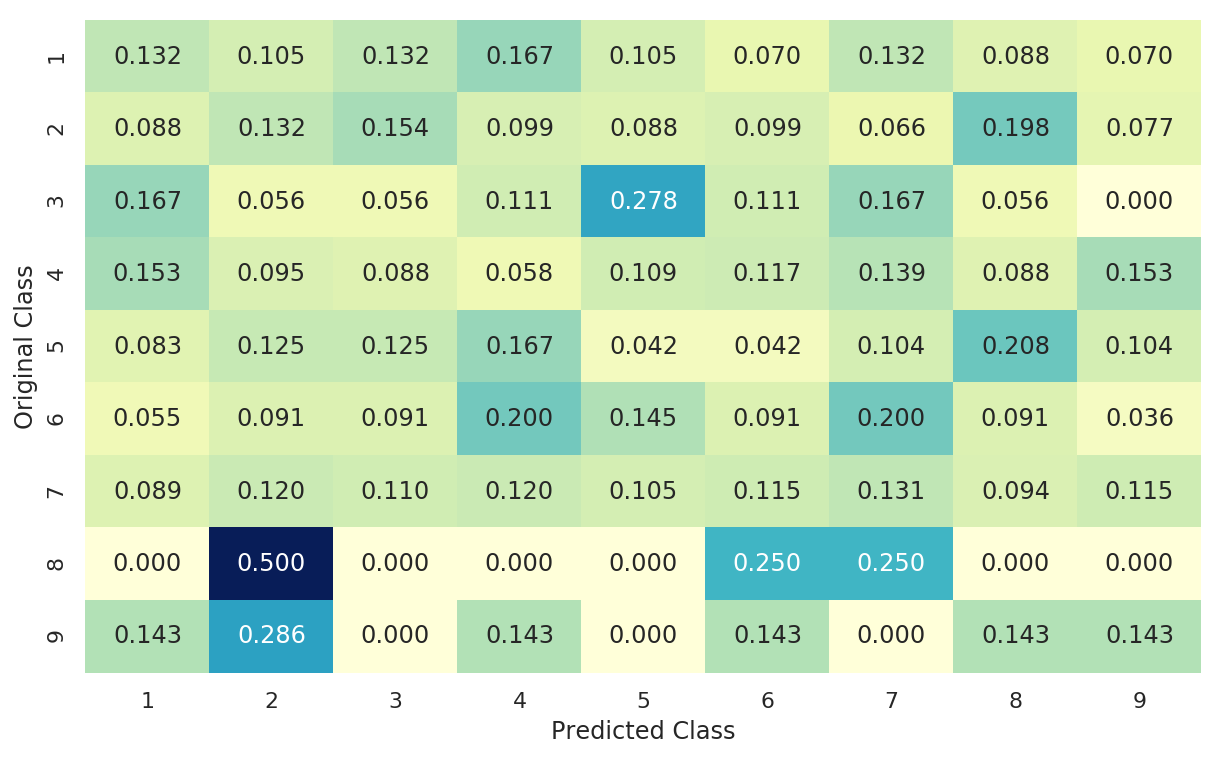

In [244]:
plot_confusion_matrix(y_test, y_test_pred)